In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import pickle
from modules.functions import pymatgen_comp, data_generator_vec, check_cuda
from modules.pytorch_models import conditional_VAE, Generator, Discriminator
from modules.trained_models import get_uts_without_grain
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from sklearn.neighbors import KernelDensity
import torch.nn as nn
import tqdm
import seaborn as sns
import umap
import json

2022-11-02 10:51:42.062586: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
el_list_loc = 'misc/element_order_uts.pkl'
with open(el_list_loc,'rb') as fid:
    el_list = pickle.load(fid)

with open('misc/scaler_y.pkl','rb') as fid:
    uts_scaler = pickle.load(fid)

# VAE

In [4]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'])
vec_comps = comp_dset.real_data
y = to_train_df['uts1200C'].values.reshape(-1,1).astype('float32')
y_scaled = uts_scaler.transform(y)

In [5]:
input_dim = vec_comps.shape[1]
batch_size = 1024
num_epochs = 100
learning_rate = 0.0001
latent_size = 4
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
vae = conditional_VAE(input_dim,1,latent_size).to(device)
optimizer = optim.Adam(vae.parameters(), lr=learning_rate)

In [6]:
Xy = [[vec_comps[i], y_scaled[i]] for i in range(vec_comps.shape[0])]
dataloader = torch.utils.data.DataLoader(
    Xy, batch_size=batch_size,
    shuffle=True, 
    pin_memory=torch.cuda.is_available())
for epoch in range(num_epochs):
    overall_loss = 0
    for batch_idx,data in enumerate(dataloader):
        inputs, cond = data
        if torch.cuda.is_available():
            inputs = inputs.cuda()
            cond = cond.cuda()
        optimizer.zero_grad()
        decoded, sigmoid, input_vae, mu, sigma = vae(inputs,cond)
        loss, recons_loss, kld_loss = vae.loss_function(decoded,sigmoid,input_vae,mu,sigma)
        overall_loss += loss.item()
        loss.backward()
        optimizer.step()
        #print(f'loss: {loss}, Reconstruction_Loss:{recons_loss}, KLD:{-kld_loss}')
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")


	Epoch 1 complete! 	Average Loss:  3.906534164508974e-05
	Epoch 2 complete! 	Average Loss:  3.649513058586639e-05
	Epoch 3 complete! 	Average Loss:  3.56763499439694e-05
	Epoch 4 complete! 	Average Loss:  3.493379805480469e-05
	Epoch 5 complete! 	Average Loss:  3.4355000984347e-05
	Epoch 6 complete! 	Average Loss:  3.403787394001318e-05
	Epoch 7 complete! 	Average Loss:  3.3869736349019645e-05
	Epoch 8 complete! 	Average Loss:  3.380837383288467e-05
	Epoch 9 complete! 	Average Loss:  3.3768001131565225e-05
	Epoch 10 complete! 	Average Loss:  3.373408657022413e-05
	Epoch 11 complete! 	Average Loss:  3.373124921133488e-05
	Epoch 12 complete! 	Average Loss:  3.371204438735731e-05
	Epoch 13 complete! 	Average Loss:  3.3707373156423934e-05
	Epoch 14 complete! 	Average Loss:  3.368782351820052e-05
	Epoch 15 complete! 	Average Loss:  3.37049118322532e-05
	Epoch 16 complete! 	Average Loss:  3.369251909051937e-05
	Epoch 17 complete! 	Average Loss:  3.3696193382969466e-05
	Epoch 18 complete! 	Av

In [7]:
import torch.nn as nn
generated = []
vec_comps_t = torch.from_numpy(vec_comps)
y_scaled_t = torch.from_numpy(y_scaled)
if torch.cuda.is_available():
    vec_comps_t = vec_comps_t.cuda()
    y_scaled_t = y_scaled_t.cuda()
res = vae.generate(vec_comps_t,y_scaled_t.cuda()).to('cpu').detach().numpy()

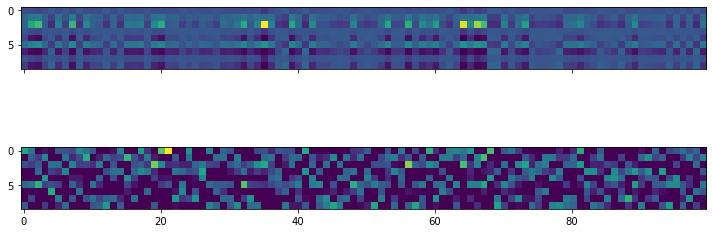

In [9]:
generated = res
fig,ax = plt.subplots(2,1,figsize=(10,5), sharex = True, sharey=True)
ax[0].imshow(generated[:100,:].T)
ax[1].imshow(comp_dset.real_data[:100,:].T)
plt.tight_layout()

In [10]:
_,_,_, mu, logvar = vae(vec_comps_t,y_scaled_t)
z = vae.reparameterize(mu,logvar)

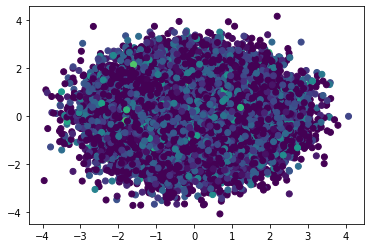

In [11]:
c = vec_comps[:,-2]
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
transformed = pca.fit_transform(z.to('cpu').detach().numpy())
plt.scatter(transformed[:,0],transformed[:,1], c=c)

In [13]:
import umap
reducer = umap.UMAP()
transformed_umap = reducer.fit_transform(z.to('cpu').detach().numpy())

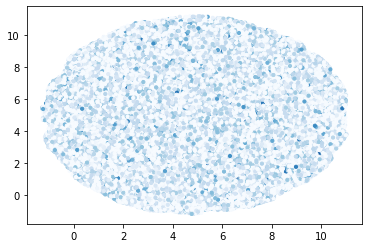

In [39]:
plt.scatter(transformed_umap[:,0],transformed_umap[:,1], c=c.reshape(-1,1), cmap = 'Blues', s=10)

# GAN

In [4]:
dataset = pd.read_csv('dataset/synthetic_dataset.csv', index_col = 0)
to_train_df = dataset[dataset['uts1200C']>0].copy()
comp_dset = data_generator_vec(to_train_df['Composition'], el_list=el_list)
vec_comps = comp_dset.real_data
y = to_train_df['uts1200C'].values.reshape(-1,1).astype('float32')
y_scaled = uts_scaler.transform(y)
kde = KernelDensity(kernel='gaussian',bandwidth=0.5)
v = kde.fit(y_scaled)

In [5]:
def prop_sampler(n_samples):
    return kde.sample(n_samples).astype('float32')

def noise_sampler(N, z_dim):
    return np.random.normal(size=[N, z_dim]).astype('float32')


def plot(points,dset, title,  thresh=0.01):

    fig, ax = plt.subplots(2, 2, figsize=(8, 8))
    ax = ax.flatten()
    ax[0].set_title(title)
    ax[0].violinplot(points, np.arange(points.shape[1]))
    ax[0].set_xticks(np.arange(dset.size))
    ax[0].set_xticklabels(dset.elements)
    s = points.sum(axis=1)
    if np.max(s) - np.min(s) < 0.010:
        ax[1].hist(s, np.linspace(0.990, 1.010, 6))
    else:
        ax[1].hist(s)
    ax[2].hist(points.flatten())
    ne = (points > thresh).sum(axis=1)
    ax[3].hist(ne, np.arange(0, 12), width=0.80)
    plt.show()
    plt.close()


In [6]:
batch_size =1000
minibatch_size = batch_size
prop_dim = y_scaled.shape[1]
latent_dim = 4
gen_in = latent_dim + prop_dim
hidden = gen_in*2
n_hidden = 3
gen_out = comp_dset.size
generator = Generator(gen_in,n_hidden,hidden,gen_out)
discriminator = Discriminator(gen_out+prop_dim,n_hidden,hidden,1)
optim_betas = (0.5, 0.999)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001,betas=optim_betas)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001,betas=optim_betas)
loss = nn.BCELoss()
d_steps = 1
g_steps = 1
prefix = 'Epoch'
cuda = check_cuda()
num_iterations = int(1e4)
log_interval = int(5e2)

In [7]:
if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()

In [8]:
def d_loop(dset=comp_dset, scaled_props = y_scaled):
  discriminator_optimizer.zero_grad()
  train_data, train_idx = dset.sample(batch_size)
  train_prop = scaled_props[train_idx]
  d_real_data = torch.from_numpy(train_data)
  d_real_prop = torch.from_numpy(train_prop)
  if cuda:
        d_real_data = d_real_data.cuda()
        d_real_prop = d_real_prop.cuda()
  
  true_discriminator_out = discriminator(d_real_data,d_real_prop)
  true_labels = torch.ones_like(true_discriminator_out)
  true_discriminator_loss = loss(true_discriminator_out, true_labels)


  d_gen_input = torch.from_numpy(noise_sampler(batch_size, latent_dim))
  d_gen_prop = prop_sampler(batch_size)
  d_gen_prop =  torch.from_numpy(d_gen_prop)#sample between lowest and highest LC values, uniform 
  if cuda:
        d_gen_input = d_gen_input.cuda()
        d_gen_prop = d_gen_prop.cuda()
  with torch.no_grad():
        generated_data = generator(d_gen_input,d_gen_prop)
  
  generator_discriminator_out = discriminator(generated_data.detach(),d_gen_prop)
  generator_discriminator_loss = loss(generator_discriminator_out, torch.zeros_like(generator_discriminator_out))
  discriminator_loss = (true_discriminator_loss + generator_discriminator_loss) / 2
  discriminator_loss.backward()
  discriminator_optimizer.step()

In [9]:
def g_loop():
  generator_optimizer.zero_grad()
  
  d_gen_input = torch.from_numpy(noise_sampler(batch_size, latent_dim))
  d_gen_prop = prop_sampler(batch_size)
  d_gen_prop =  torch.from_numpy(d_gen_prop)#sample between lowest and highest LC values, uniform 
  if cuda:
        d_gen_input = d_gen_input.cuda()
        d_gen_prop = d_gen_prop.cuda()
  generated_data = generator(d_gen_input,d_gen_prop)
  generator_discriminator_out = discriminator(generated_data,d_gen_prop)
  true_labels = torch.ones_like(generator_discriminator_out)
  generator_loss = loss(generator_discriminator_out, true_labels)
  generator_loss.backward()
  generator_optimizer.step()

In [10]:
def g_sample():
    with torch.no_grad():
        gen_input = torch.from_numpy(noise_sampler(minibatch_size, latent_dim))
        #prop_input = np.random.uniform(max,min,(minibatch_size,prop_dim)).astype('float32')
        prop_input = prop_sampler(minibatch_size)
        prop_input =  torch.from_numpy(prop_input)
        if cuda:
            gen_input = gen_input.cuda()
            prop_input = prop_input.cuda()
        g_fake_data = generator(gen_input,prop_input)
        return g_fake_data.cpu().numpy()

In [ ]:
samples = []
for it in tqdm.notebook.tqdm(range(num_iterations)):
    d_infos = []
    for d_index in range(d_steps):
        d_loop()
    for g_index in range(g_steps):
        g_loop()
    
    if it == 0 or (it + 1) % log_interval == 0:
        g_fake_data = g_sample()
        samples.append(g_fake_data)
        plot(g_fake_data, title='[{}] Iteration {}'.format(prefix, it+1),dset = comp_dset)
        train_epoch = it+1
model_path = 'saved_models'
model_scripted = torch.jit.script(generator.cpu())
model_scripted.save(os.path.join(model_path, 'GAN_generator.pt'))

In [7]:
model_path = 'saved_models'
if os.path.exists(os.path.join(model_path, 'GAN_generator.pt')):
    generator = torch.jit.load(os.path.join(model_path, 'GAN_generator.pt'), map_location='cpu')
else:
    print('train model first!')

## Parity plots

In [8]:
scaled_fixed_conds = np.linspace(0,1,5) + 0.25
fixed_cond_vals = uts_scaler.transform(scaled_fixed_conds.reshape(-1,1))
n_samples = 500
parity_dict = {}
for i,val in enumerate(fixed_cond_vals):
    ones_arr = (np.ones((n_samples,1))*val).astype('float32')
    random_noise = noise_sampler(n_samples,latent_dim)
    gen_input = torch.from_numpy(random_noise)
    prop_input = torch.from_numpy(ones_arr)
    if cuda:
        generator = generator.cuda()
        gen_input = gen_input.cuda()
        prop_input = prop_input.cuda()
    g_fake_data = generator(gen_input,prop_input).to('cpu').detach().numpy()
    uts_synthetic = [get_uts_without_grain(i.reshape(1,-1)).item() for i in g_fake_data]
    scaled_val = scaled_fixed_conds[i].item()
    parity_dict[scaled_val] = np.array(uts_synthetic)    

Text(0, 0.5, 'Sampled UTS1200C')

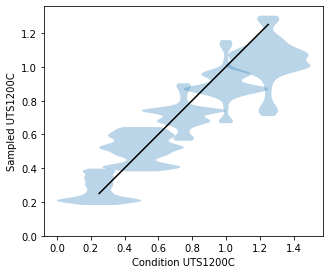

In [9]:
vals = np.array([np.array(x) for x in parity_dict.values()])
targets = scaled_fixed_conds
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(5,5))
_=ax.violinplot(vals.T, targets, showextrema=False, bw_method=0.2)
ax.plot([targets.min(), targets.max()], [targets.min(), targets.max()], 'k-')
ax.set_ylim(0)
ax.set_aspect('equal')
ax.set_xlabel('Condition UTS1200C')
ax.set_ylabel('Sampled UTS1200C')

## Sampling z and determining W regions

In [14]:
n_samples  =10000
uniform_noise = np.random.uniform(0,1, size = (n_samples, latent_dim)).astype('float32')
gen_input = torch.from_numpy(uniform_noise)
prop_input = prop_sampler(n_samples)
prop_input =  torch.from_numpy(prop_input)
if cuda:
        generator = generator.cuda()
        gen_input = gen_input.cuda()
        prop_input = prop_input.cuda()
g_fake_data = generator(gen_input,prop_input).to('cpu').detach().numpy()
uts_synthetic = [get_uts_without_grain(i.reshape(1,-1)).item() for i in g_fake_data]
w_ind = np.argwhere(el_list == 'W').item()
w_content = g_fake_data[:,w_ind]

In [15]:
reducer = umap.UMAP()
transformed_umap = reducer.fit_transform(uniform_noise)

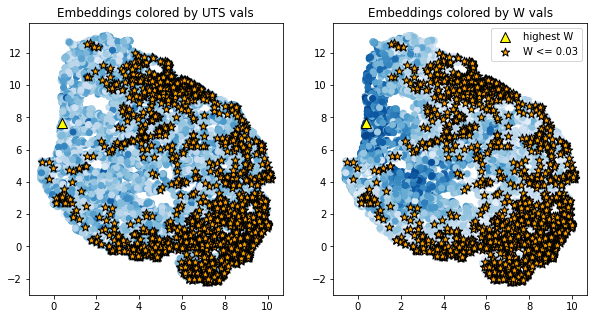

In [16]:
fig, ax  = plt.subplots(1,2,figsize=(10,5))
list_fill = ['UTS','W']
for i,c in enumerate([prop_input.to('cpu').detach().numpy(),w_content]):
    ax[i].scatter(transformed_umap[:,0],transformed_umap[:,1], c=c, cmap = 'Blues')
    max, min = np.argmax(w_content), np.argwhere(w_content<=0.03)
    ax[i].scatter(transformed_umap[max,0],transformed_umap[max,1],marker='^', c= 'yellow', label = 'highest W', edgecolors='black', s = 100)
    ax[i].scatter(transformed_umap[min,0],transformed_umap[min,1],marker='*', c= 'orange', label = 'W <= 0.03',edgecolors='black', s = 80)
    ax[i].set_title('Embeddings colored by {} vals'.format(list_fill[i]))
plt.legend()


### Correlation with latent dim

In [8]:
np.random.seed(0)
n_samples  =10000
uniform_noise = np.random.uniform(0,1, size = (n_samples, latent_dim)).astype('float32')
gen_input = torch.from_numpy(uniform_noise)
prop_input = prop_sampler(n_samples)
prop_input =  torch.from_numpy(prop_input)
if cuda:
        generator = generator.cuda()
        gen_input = gen_input.cuda()
        prop_input = prop_input.cuda()
g_fake_data = generator(gen_input,prop_input).to('cpu').detach().numpy()
uts_synthetic = [get_uts_without_grain(i.reshape(1,-1)).item() for i in g_fake_data]
w_ind = np.argwhere(el_list == 'W').item()
w_content = g_fake_data[:,w_ind]
start = uniform_noise[np.argmax(g_fake_data[:,w_ind])]
starting_w = g_fake_data[:,w_ind][np.argmax(g_fake_data[:,w_ind])]
start_prop = prop_input[np.argmax(g_fake_data[:,w_ind])]
start_comp = g_fake_data[np.argmax(g_fake_data[:,w_ind])]

In [9]:
from scipy.stats import pearsonr
for i in range(uniform_noise.shape[1]):
    print(f'Correlation with dim {i+1} : {pearsonr(uniform_noise[:,i], w_content)[0]}')

Correlation with dim 1 : -0.2746026830202452
Correlation with dim 2 : 0.4565979136865997
Correlation with dim 3 : -0.3479262245107867
Correlation with dim 4 : 0.5506664707599456


In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
kf.get_n_splits(uniform_noise)
predicted_w = []
for i, (train_idx,test_idx) in enumerate(kf.split(uniform_noise)):
    X_train, y_train = uniform_noise[train_idx], w_content[train_idx]
    X_test, y_test = uniform_noise[test_idx],w_content[test_idx]
    LNRmodel = LinearRegression()
    LNRmodel.fit(X_train,y_train)
    y_pred = LNRmodel.predict(X_test)
    predicted_w.append(pearsonr(y_pred,y_test)[0])
np.mean(predicted_w), np.std(predicted_w)

(0.8411643239680238, 0.007716256808552342)

In [11]:
np.random.seed(0)
LNRmodel = LinearRegression()
LNRmodel.fit(uniform_noise, w_content)
dominant_dir = LNRmodel.coef_

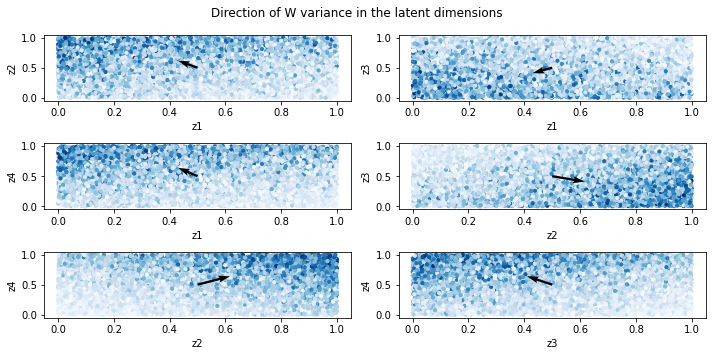

In [12]:
from itertools import combinations
perm = combinations(np.arange(uniform_noise.shape[1]), 2)  
fig,ax = plt.subplots(3,2,figsize = (10,5))
ax = ax.flatten()
for k,i in enumerate(list(perm)):
    a,b = i
    ax[k].scatter(uniform_noise[:,a],uniform_noise[:,b],s = 10, c = w_content[:],cmap = 'Blues')
    ax[k].quiver(0.5,0.5,dominant_dir[a],dominant_dir[b],angles='xy', scale_units='xy', scale=1)
    ax[k].set_xlabel('z{}'.format(a+1))
    ax[k].set_ylabel('z{}'.format(b+1))

plt.suptitle('Direction of W variance in the latent dimensions')
plt.tight_layout()

In [13]:
def prop_sampler_mod(n_samples, fixed = False, val = False):
    if fixed:
        ones = np.ones((n_samples,1))
        if not val:
            return (ones*kde.sample(1)).astype('float32')
        else:
            return (ones*val).astype('float32')
    else:
        return kde.sample(n_samples).astype('float32')

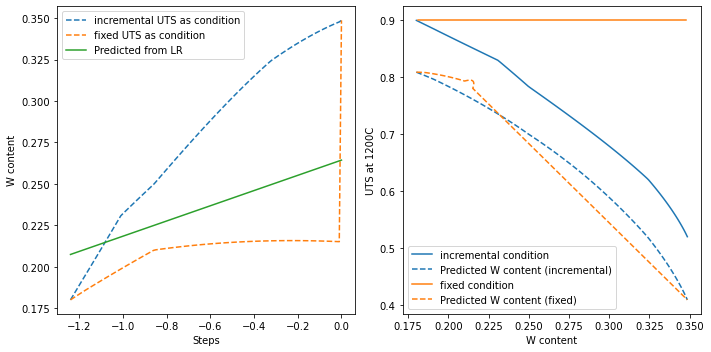

In [57]:
np.random.seed(0)
fixed_uts = uts_scaler.transform(np.array([[0.90]]).reshape(-1,1))
count = np.arange(fixed_uts,start_prop.to('cpu').detach().numpy(),-0.01).astype('float32').reshape(-1,1)
fixed_bin = [False,True]
fig,ax = plt.subplots(1,2, figsize = (10,5))
ax = ax.ravel()
fixed_dict, inc_dict = {},{}
for bin in fixed_bin:
        i = int(bin)
        if bin:
                prop_input = prop_sampler_mod(len(count),fixed = bin, val = fixed_uts)
                label = 'fixed UTS as condition'
        else:
                prop_input = count
                label = 'incremental UTS as condition'
        prop_input[-1] = start_prop.to('cpu').detach().numpy()
        prop_input =  torch.from_numpy(prop_input)
        
        n_points = np.arange(-len(prop_input)+1,1,1).reshape(-1,1)*0.01
        mods = n_points*dominant_dir
        static_noise=np.ones((len(mods),1))*start
        new_latent_dims = static_noise + mods
        new_predicted_w = LNRmodel.predict(new_latent_dims)
        gen_input = torch.from_numpy(new_latent_dims.astype('float32'))
        if cuda:
                generator = generator.cuda()
                gen_input = gen_input.cuda()
                prop_input = prop_input.cuda()
        g_fake_data_fixed = generator(gen_input,prop_input).to('cpu').detach().numpy()
        gen_w_content = g_fake_data_fixed[:,w_ind]
        g_fake_data_uts = np.array([get_uts_without_grain(i.reshape(1,-1)).item() for i in g_fake_data_fixed]).reshape(-1,1)
        ax[0].plot(n_points,gen_w_content, linestyle='dashed', label = label)

        
        if not bin:
                c = 'tab:blue'
                label = 'incremental'
                ax[1].plot(gen_w_content, uts_scaler.inverse_transform(prop_input.to('cpu').detach().numpy()), color = c, label = '{} condition'.format(label))
        else:
                c = 'tab:orange'
                label = 'fixed'
                ax[1].axhline(y = 0.9, xmin = 0.05, xmax = 0.95, color = c, label = '{} condition'.format(label))
        ax[1].plot(gen_w_content, g_fake_data_uts, color = c, linestyle = 'dashed', label = 'Predicted W content ({})'.format(label))

        if bin:
                fixed_dict = {
                        'predicted_w' : new_predicted_w.tolist(),
                        'actual_w':gen_w_content.tolist(),
                        'g_fake_data':g_fake_data_fixed.tolist(),
                        'g_fake_data_uts':g_fake_data_uts.tolist(),
                }
        elif not bin:
                inc_dict = {
                        'predicted_w' : new_predicted_w.tolist(),
                        'actual_w':gen_w_content.tolist(),
                        'g_fake_data':g_fake_data_fixed.tolist(),
                        'g_fake_data_uts':g_fake_data_uts.tolist(),
                }

ax[0].plot(n_points,new_predicted_w, label = 'Predicted from LR')
ax[0].set_xlabel('Steps')
ax[0].set_ylabel('W content')
ax[1].set_xlabel('W content')
ax[1].set_ylabel('UTS at 1200C')
ax[0].legend()
ax[1].legend()

plt.tight_layout()



In [61]:
to_consider = sorted(['Nb','Mo','Zr','Ti','V','W','Hf','Cr','Ta'])
results_dict = {
    'inverse':{
        'constants':{
        'uniform_noise':uniform_noise.tolist(),
        'w_content':w_content.tolist(),
        'dominant_dir':dominant_dir.tolist(),
        'to_consider':to_consider
        },
    'fixed': fixed_dict,
    'inc' : inc_dict
    }
}
with open('results.json','w') as fid:
    json.dump(results_dict,fid)

In [62]:
import pymatgen.core as mg
def decode(vec, elem_list, thresh=0.03):
    vec[vec<thresh] = 0
    vec /= vec.sum()
    #comp = ''
    #for i, x in enumerate(vec):
    #    if x >= thresh:
    #        comp += elem_list[i] + '{:.2f} '.format(x)
    return vec #mg.Composition(comp)

In [63]:
test  = decode(g_fake_data_fixed[-1],el_list)
test2 = decode(g_fake_data_fixed[0],el_list)
np.sum(list(test))

1.0

In [52]:
json_dict = {
    'start_comp' : test.tolist(),
    'start_uts' : g_fake_data_uts[-1].item(),
    'start_w_content' : test[w_ind].item(),
    'end_w_content': test2[w_ind].item()
}
with open('misc/starting_comp.json','w') as fid:
    json.dump(json_dict,fid)

## Optimization scheme for finding z of A8 composition

In [143]:
def to_vec(pymatgen_comp, el_list = el_list):
    vec_arr = np.zeros((1,len(el_list)))
    for i in pymatgen_comp.get_el_amt_dict().keys():
        ind = np.argwhere(np.array(el_list) == i)
        vec_arr[:,ind] = pymatgen_comp.get_atomic_fraction(i)
    return vec_arr

In [433]:
to_optimize_comp = pymatgen_comp(['Nb6Mo3W27Zr30Ti30V3'])[0]
comp_start = to_vec(to_optimize_comp)
uts_start = uts_scaler.transform(get_uts_without_grain(comp_start).reshape(-1,1))
def get_loss(z, uts_start = uts_start,comp_start = comp_start, generator = generator):
    z = torch.from_numpy(z.reshape(1,-1).astype('float32'))
    uts_start = torch.from_numpy(uts_start)
    if cuda:
        generator = generator.cuda()
        z = z.cuda()
        uts_start = uts_start.cuda()
    g_fake = generator(z,uts_start).to('cpu').detach().numpy()

    targs = (comp_start>0).astype('float32')
    present = (g_fake>0).astype('float32')
    #return g_fake

    return np.sum(np.absolute((g_fake - comp_start)))

In [434]:
i = 0
loss = np.inf
while i < 1000:
    z = noise_sampler(1,latent_dim)
    loss_temp= get_loss(z)
    if loss_temp < loss:
        #print(fake)
        loss = loss_temp
        print(z)
    i+=1

[[-0.2096304 -0.6596488 -0.5360625 -0.7375632]]
[[0.19967417 0.636891   1.6980404  1.8606158 ]]
[[ 0.79291004 -0.5418628   0.078794    1.9496559 ]]
[[-0.32182634  0.6330057   0.4657112   0.30463362]]
[[ 0.03322163  0.41624078 -1.7015704  -0.7341887 ]]
[[ 0.6355279   0.29898807 -0.6763262   0.44186443]]
[[ 1.1196334   0.8587444  -0.19411498  0.50010556]]
[[ 0.7988821   0.35882592 -0.49047974  0.50422585]]
[[ 0.3661143   0.26403165 -1.1100227  -0.03655161]]
[[ 0.7567975  -0.187028    0.05451491  1.3804506 ]]
[[ 0.60146564 -1.5049213  -0.14780009  2.1720836 ]]


In [435]:
from scipy.optimize import minimize
fun = lambda x: get_loss(x)
res = minimize(fun,z,method='SLSQP')

In [436]:
z = torch.from_numpy(res.x.reshape(1,-1).astype('float32'))
uts_start = torch.from_numpy(uts_start)
if cuda:
        generator = generator.cuda()
        z = z.cuda()
        uts_start = uts_start.cuda()
g_fake = generator(z,uts_start).to('cpu').detach().numpy()

In [438]:
g_fake

array([[1.4012985e-45, 7.0064923e-45, 1.5694543e-43, 4.3487528e-04,
        1.5414283e-44, 0.0000000e+00, 3.7347749e-02, 0.0000000e+00,
        1.6730407e-01, 3.3829692e-01, 4.0637655e-44, 2.0451531e-40,
        0.0000000e+00, 3.5716969e-01, 2.5563952e-02, 7.3706458e-12,
        5.7107322e-02, 1.6775358e-02]], dtype=float32)

In [439]:
comp_start

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.03030303, 0.06060606,
        0.        , 0.        , 0.        , 0.        , 0.3030303 ,
        0.03030303, 0.3030303 , 0.27272727]])